In [1]:
%matplotlib inline

from satsense.features import (NirNDVI, HistogramOfGradients, Pantex, Sift,
                               Lacunarity, Texton)
from satsense.util import multipolygon2mask, show_multipolygon
from satsense import Image
from pathlib import Path
import matplotlib.pyplot as plt
import geopandas
import fiona
import xarray as xr
from shapely.geometry import MultiPolygon, shape
import shapely
import numpy as np

home = Path.home()
data = home / 'Data' / 'Dynaslum' / 'Bangalore'
features_path = data / 'features' / '10x10_20160125_wv03_002_hcs_bl_7'

/usr/local/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
features = xr.open_dataset(features_path / 'NirNDVI_10_10.nc')

extent_shape = (features.dims['lat'], features.dims['lon'])
print(extent_shape)

(3160, 5145)


(array(77.67621237), array(12.90629689), array(77.53385141), array(12.99372268))


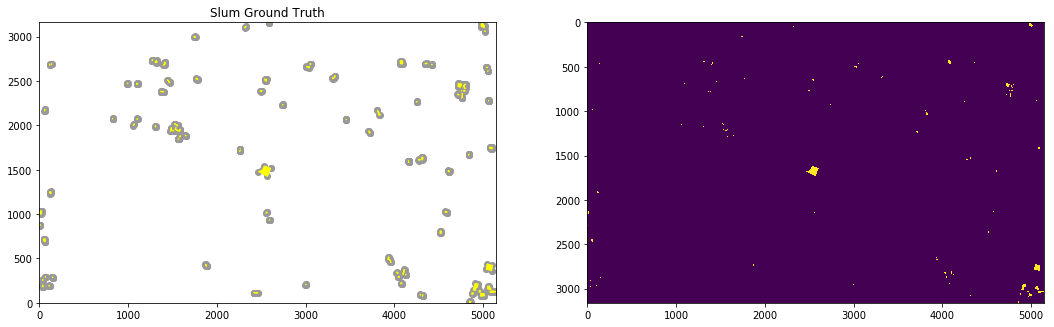

In [3]:
# Load the ground truth shapefile
ground_truth_file = data / 'ground_truth' / 'slum_tile_002.shp'
ground_truth = fiona.open(ground_truth_file)


# Get the extent from the loaded data
y0 = features.lat[-1].data
y1 = features.lat[0].data

x0 = features.lon[-1].data
x1 = features.lon[0].data

extent = (x0, y0, x1, y1)
print(extent)

# Transform the shapefile into a multipolygon and move it to the 0,0 point
shapes = list(ground_truth.items(bbox=extent))
clipped_ground_truth = MultiPolygon(shape(p['geometry']) for i, p in shapes)
clipped_ground_truth = shapely.affinity.translate(clipped_ground_truth,
                                                  -clipped_ground_truth.bounds[0],
                                                  -clipped_ground_truth.bounds[1])


# Calculate the scaling factor to scale the ground truth to the feature shape
x_scale = extent_shape[1] / clipped_ground_truth.bounds[2]
y_scale = extent_shape[0] / clipped_ground_truth.bounds[3]
clipped_ground_truth = shapely.affinity.scale(clipped_ground_truth, x_scale, y_scale, origin=(0,0))

# Convert the shape to a mask
mask = multipolygon2mask(clipped_ground_truth, extent_shape, all_touched=True)
# Invert the mask in the y axis, as latitudes are inverted
mask = mask[::-1, :]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18,18))
show_multipolygon(clipped_ground_truth, ax0, True, clipped_ground_truth.bounds, 'yellow', 1, 'Slum Ground Truth')
ax1.imshow(mask[:, :])
plt.show()

In [25]:
from satsense.image import FeatureVector

def load_feature_vector(features, path, normalize=False):
    """Load feature values from file."""
    feature_vector = []
    for feature in features:
        vector = FeatureVector.from_file(feature, path).vector
        print('Loaded feature {} min: {}, max: {}, mean: {}, std: {}'
              .format(feature.name, vector.min(), vector.max(), vector.mean(), vector.std()))
        # flatten window/feature_size dimensions
        vector.shape = (vector.shape[0], vector.shape[1], -1)
        
        
        if normalize:
            flat_vector = vector.reshape(-1, vector.shape[2])
            maxes = flat_vector.max(axis=0)
            mins = flat_vector.min(axis=0)
            vector = 2 * ((vector - mins) / (maxes - mins)) - 1
        
        feature_vector.append(vector)
    feature_vector = np.ma.dstack(feature_vector)
    return feature_vector


In [24]:
from satsense.features import NirNDVI, NDWI, HistogramOfGradients, Pantex, ScipyHoG
from sklearn.cluster import MiniBatchKMeans

mkb = MiniBatchKMeans(n_clusters=32, random_state=42)

windows = [(10, 10), (25, 25), (50, 50)]
features = [
    NirNDVI(windows),
    NDWI(windows),
    # HistogramOfGradients(windows),
    ScipyHoG(windows),
#    Pantex(windows),
#    Sift(windows, mkb),
#    Texton(windows, mkb),
]

feature_vector = load_feature_vector(features, str(features_path), normalize=True)
ma = np.ma.masked_array(mask, feature_vector.mask[:, :, 0])

print('Feature Vector shape: {} min: {}, max: {}, mean: {}'
              .format(feature_vector.shape, feature_vector.min(), feature_vector.max(), feature_vector.mean()))

Loaded feature NirNDVI min: -0.5310377478599548, max: 0.6325869560241699, mean: 0.05227899622826093, std: 0.1520219166329294
Loaded feature NDWI min: -0.30748435854911804, max: 0.7264034748077393, mean: 0.1663552925689171, std: 0.1426739838720526
Loaded feature ScipyHoG min: 0.0, max: 3.078760862350464, mean: 0.6143064943923202, std: 0.8598989014465038
Feature Vector shape: (3160, 5145, 21) min: -1.0, max: 1.0, mean: -0.3852833134066366


In [26]:
import math
# Create samples using the ground truth mask
half = math.floor(feature_vector.shape[1] / 2)
quarter = math.floor(half / 2)
training_extent = slice(0, half)
test_extent = slice(half, half+quarter)
validation_extent = slice(half+quarter, feature_vector.shape[1])

print('Training on:', training_extent)
print('Testing on:', test_extent)
print('Validating on:', validation_extent)

train_samples = 2000
test_samples = 1000

# use N times more non_slum samples
sample_bias = 8

# Randomly select pixels for training
slum_choices = np.argwhere(ma[:, training_extent].filled(0))
non_slum_choices = np.argwhere(1 - ma[:, training_extent].filled(1))

slum_samples = np.transpose(slum_choices[np.random.choice(len(slum_choices), train_samples)])
non_slum_samples = np.transpose(non_slum_choices[np.random.choice(len(non_slum_choices), sample_bias*train_samples)])

# Select the features using the samles
y, x = slum_samples
train_slum_features = feature_vector[y, x, :]
y, x = non_slum_samples
train_non_slum_features = feature_vector[y, x, :]


# Randomly select pixels for testing
slum_choices = np.argwhere(ma[:, test_extent].filled(0))
non_slum_choices = np.argwhere(1 - ma[:, test_extent].filled(1))

slum_samples = np.transpose(slum_choices[np.random.choice(len(slum_choices), test_samples)])
non_slum_samples = np.transpose(non_slum_choices[np.random.choice(len(non_slum_choices), sample_bias*test_samples)])

# Select the features using the samles
y, x = slum_samples
test_slum_features = feature_vector[y, x, :]
y, x = non_slum_samples
test_non_slum_features = feature_vector[y, x, :]

Training on: slice(0, 2572, None)
Testing on: slice(2572, 3858, None)
Validating on: slice(3858, 5145, None)


In [27]:
from scipy.stats import ks_2samp

fset = []
for feature in range(0, train_non_slum_features.shape[1]):

    edges = np.histogram_bin_edges(np.append(train_slum_features[:, feature],
                                             train_non_slum_features[:, feature]), bins=50)
    
    slum_hist, _ = np.histogram(train_slum_features[:, feature], bins=edges, density=True)
    non_slum_hist, _ = np.histogram(train_non_slum_features[:, feature], bins=edges, density=True)
    
    ks = ks_2samp(slum_hist, non_slum_hist)
    
    if ks.pvalue < 0.05:
        print('Feature {}: {}'.format(feature, ks))
    fset.append(feature)

Feature 6: Ks_2sampResult(statistic=0.52, pvalue=1.2334523759e-06)
Feature 7: Ks_2sampResult(statistic=0.54, pvalue=4.0202302886269487e-07)
Feature 11: Ks_2sampResult(statistic=0.30000000000000004, pvalue=0.01714441234319582)
Feature 16: Ks_2sampResult(statistic=0.28, pvalue=0.03166084605179076)
Feature 17: Ks_2sampResult(statistic=0.3400000000000001, pvalue=0.004427949153760486)


In [28]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier



# Prepare the input
X_train = np.append(train_slum_features[:, fset], train_non_slum_features[:, fset], axis=0)
y_train = np.append(np.ones(train_samples), np.zeros(sample_bias*train_samples))

X_test = np.append(test_slum_features[:, fset], test_non_slum_features[:, fset], axis=0)
y_test = np.append(np.ones(test_samples), np.zeros(sample_bias*test_samples))

#clf = SVC(gamma='auto')
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.8193333333333334

In [29]:
# Get all the validation pixels
validation_features = feature_vector[:, validation_extent, fset]
val_shape = validation_features.shape
# Reshape to the correct shape for the model
validation_features = validation_features.reshape(-1, validation_features.shape[-1])

predictions = clf.predict(validation_features)

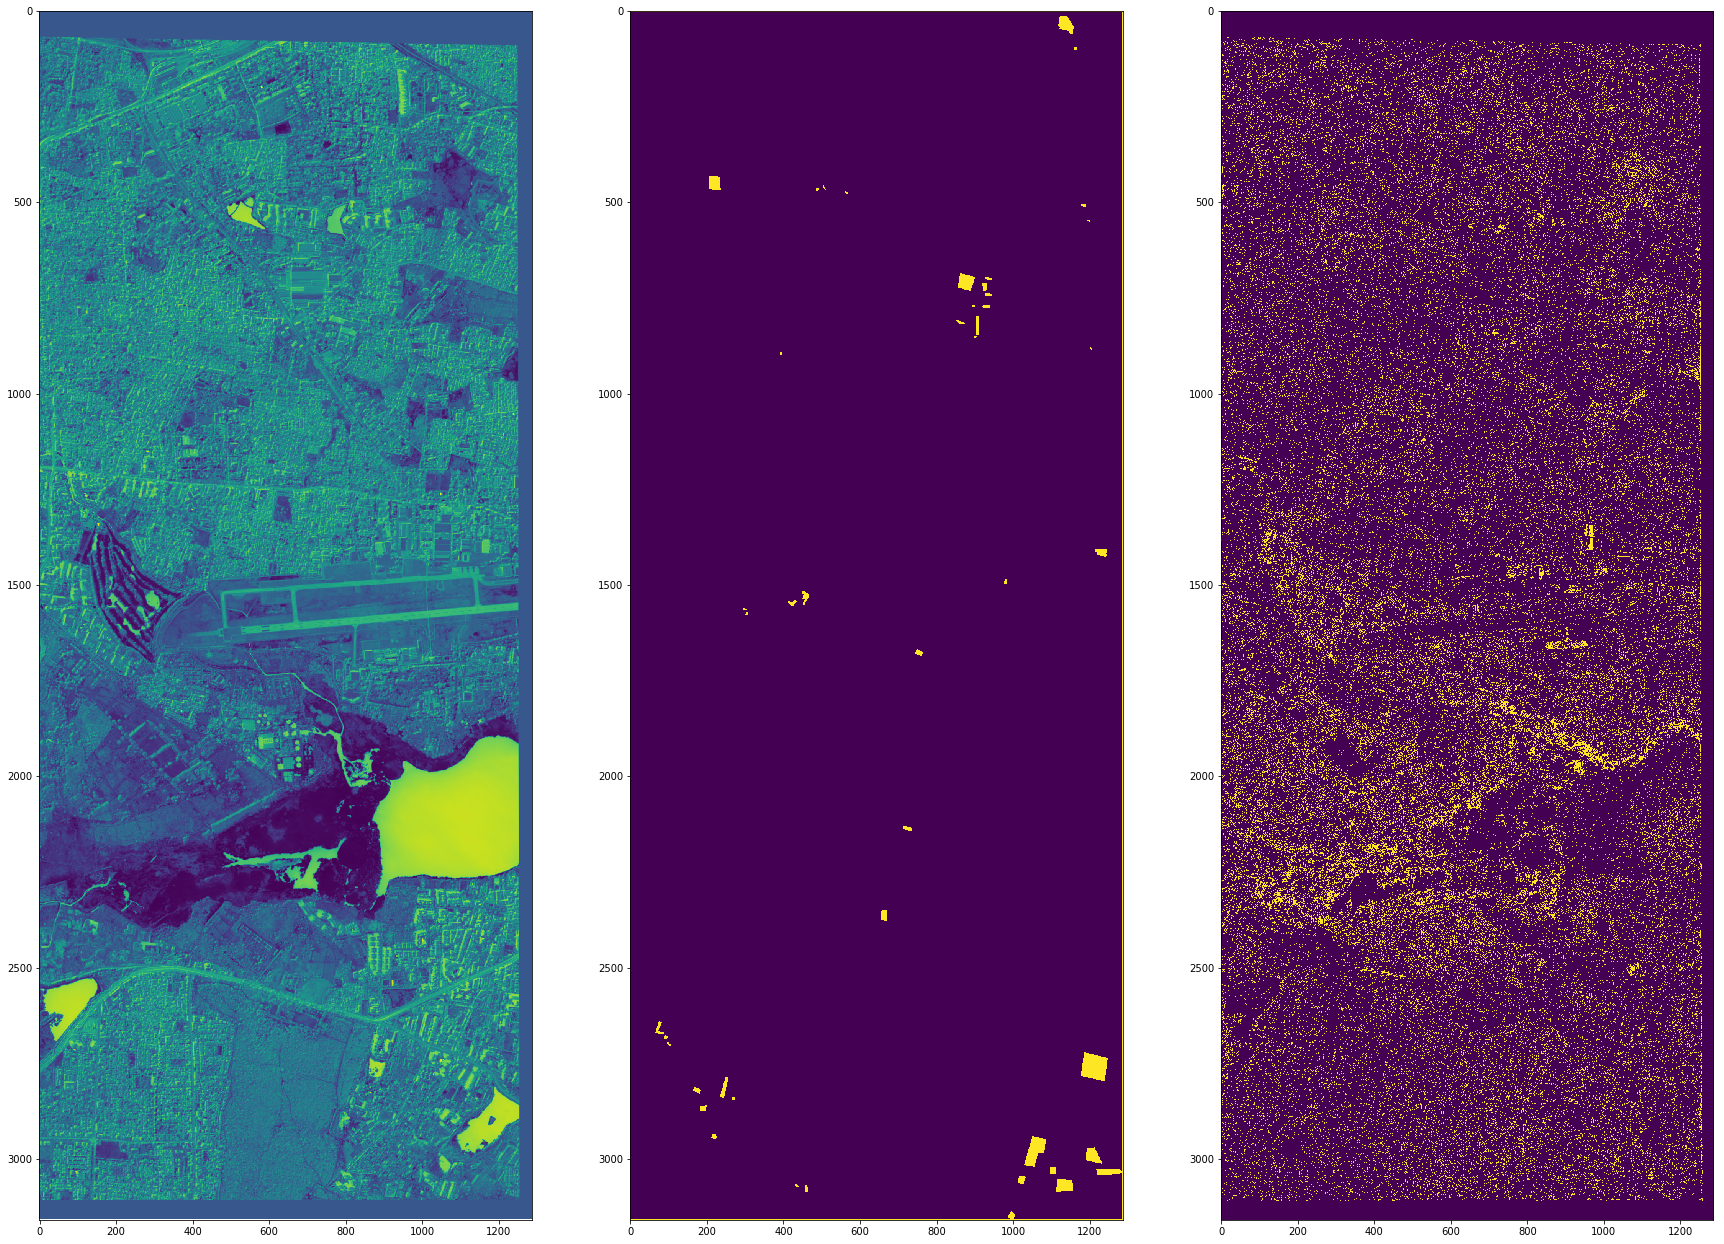

In [30]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(30,30))

ax0.imshow(validation_features.reshape(*val_shape[0:2], -1)[:, :, 4])
ax1.imshow(ma[:, validation_extent].filled(1))
ax2.imshow(predictions.reshape(val_shape[0:2]))

plt.show()

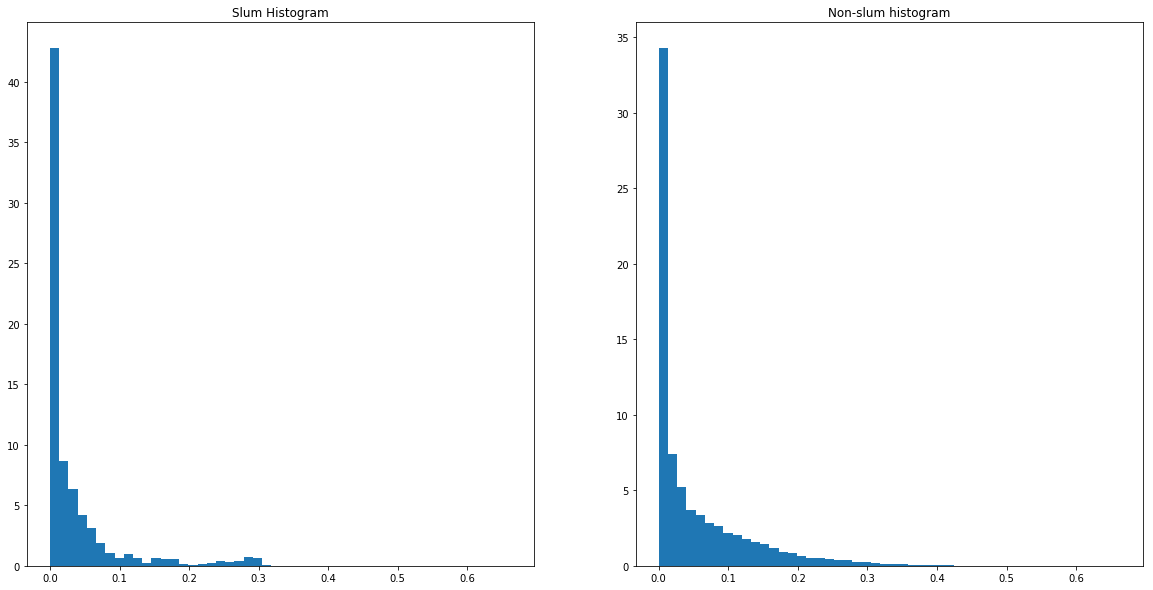

In [324]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,10))

f = 102

ax0.hist(train_slum_features[:, f], bins=edges, density=True)
ax0.set_title('Slum Histogram')

ax1.hist(train_non_slum_features[:, f], bins=edges, density=True)
ax1.set_title('Non-slum histogram')

plt.show()